Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import Encoder_Decoder_Model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/rnakaha2/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

Load Data

In [8]:
class Data(Dataset):
  def __init__(self):
    self.diff_grid = torch.tensor(np.load('../dataset/compressed_diff_grid.npz')['arr_0']).float()
    labels = np.load('../dataset/norm_diffraction_label.npz')['arr_0']
    self.phase = torch.tensor(labels[:, 0]).float()
    self.amp = torch.tensor(labels[:, 1]).float()
  def __len__(self):
    return self.diff_grid.shape[0]
  def __getitem__(self, i):
    return (self.diff_grid[i], self.phase[i], self.amp[i])

In [9]:
trn_ds = Data()
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True)

Train Model

In [10]:
# Testing Different Loss functions

#from torchmetrics import PeakSignalNoiseRatio
# from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
#lossfn =  nn.L1Loss()
lossfn =  nn.MSELoss()
#lossfn = PeakSignalNoiseRatio(data_range=1.0).to(device)
#lossfn =  MultiScaleStructuralSimilarityIndexMeasure().to(device) # must be positive number
#lossfn =  nn.BCELoss(reduction='mean')

def ModelLoss(pred1, target1, pred2, target2):
  loss1 = lossfn(pred1, target1)
  loss2 = lossfn(pred2, target2)
  return loss1, loss2

In [11]:
def train_model(model, input, target1, target2, optimizer, criterion, scheduler=None):
  model.train()
  phase_pred, amp_pred = model(input)
  loss1, loss2 = criterion(phase_pred, target1, amp_pred, target2)
  loss = loss1 + loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if(scheduler != None):
    scheduler.step()
  return loss1, loss2, loss

In [6]:
def hyperparameter(num_epochs, learning_rate, plot=True):
  if plot:
    plt.subplot(2, 1, 2, facecolor='white')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


  PtychoModel = Encoder_Decoder_Model.Model().to(device)
  torch.save(PtychoModel.state_dict(), 'initial.pth')
  criterion = ModelLoss
  
  for l_rate in learning_rate:
    PtychoModel.load_state_dict(torch.load('initial.pth'))
    #optimizer = torch.optim.AdamW(PtychoModel.parameters(), lr=l_rate, betas=(0.396, 0.899))
    optimizer = optim.SGD(lr=learning_rate, momentum=0.9)
    if plot:
      loss_hist = []
    for epoch in range(num_epochs):
      for bx, data in enumerate(trn_dl):
        diff, phase, amp = data
        diff, phase, amp = diff.to(device), phase.to(device), amp.to(device)
        loss1, loss2, loss = train_model(PtychoModel, diff, phase, amp, optimizer, criterion)

        if((epoch+1) % 200 == 0):
          print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5), " L1: ",round(loss1.item(), 7)," L2: ", round(loss2.item(), 7))
        if(plot and ((epoch+1) % 50 == 0)):
          loss_hist.append(loss.item())
    if plot:
      plt.plot(loss_hist, '-', label= 'trn_acc:'+str(l_rate))
  if plot:
    plt.legend(loc='upper right')
    plt.gcf().set_size_inches(15, 15)
    plt.show()

Epoch:  200  Training Loss:  0.14985  L1:  0.1157821  L2:  0.0340726
Epoch:  200  Training Loss:  0.17637  L1:  0.1422009  L2:  0.034165
Epoch:  400  Training Loss:  0.18058  L1:  0.1486634  L2:  0.0319149
Epoch:  400  Training Loss:  0.13037  L1:  0.1015297  L2:  0.0288371
Epoch:  600  Training Loss:  0.18198  L1:  0.1513047  L2:  0.0306731
Epoch:  600  Training Loss:  0.1283  L1:  0.0983104  L2:  0.0299848
Epoch:  800  Training Loss:  0.18015  L1:  0.1482878  L2:  0.0318629
Epoch:  800  Training Loss:  0.12943  L1:  0.1006508  L2:  0.0287809
Epoch:  1000  Training Loss:  0.16834  L1:  0.1379501  L2:  0.0303886
Epoch:  1000  Training Loss:  0.14082  L1:  0.1105758  L2:  0.0302467
Epoch:  1200  Training Loss:  0.12785  L1:  0.0978755  L2:  0.0299733
Epoch:  1200  Training Loss:  0.18116  L1:  0.1504965  L2:  0.0306609
Epoch:  1400  Training Loss:  0.16809  L1:  0.1377039  L2:  0.0303843
Epoch:  1400  Training Loss:  0.14057  L1:  0.1103279  L2:  0.0302417
Epoch:  1600  Training Loss:  

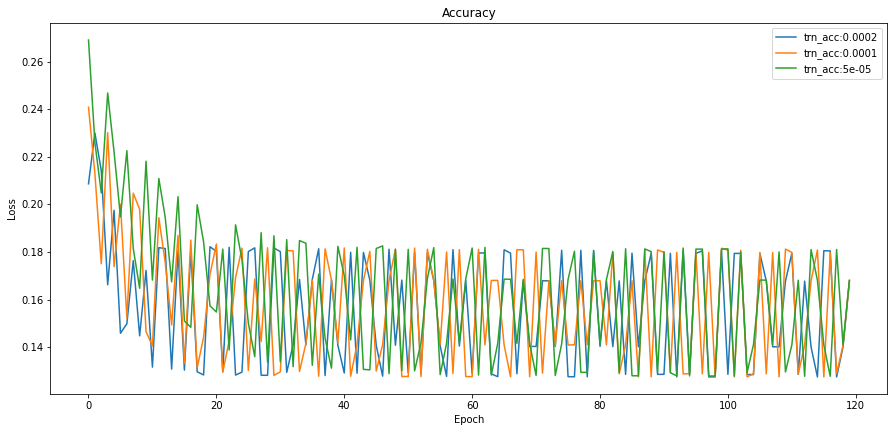

In [7]:
epochs = 3000
lr = [0.0002, 0.00001, 0.00005]
hyperparameter(epochs, lr, True)

Train Using Best Hyperparameter

In [33]:
def train(model, lr, num_epochs, step_size=5000):
  plt.subplot(2, 1, 2, facecolor='white')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  loss_hist = []
  rec_freq = num_epochs//60
  
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.3, 0.69))
  #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr/10, max_lr=lr, step_size_up=step_size, cycle_momentum=False, mode='triangular2')
  criterion = ModelLoss

  for epoch in range(num_epochs):
    for bx, data in enumerate(trn_dl):
      diff, phase, amp = data
      diff, phase, amp = diff.to(device), phase.to(device), amp.to(device)
      loss1, loss2, loss = train_model(model, diff, phase, amp, optimizer, criterion, scheduler)
      if((epoch+1) % 200 == 0):
        print("Epoch: ", (epoch+1), " Training Loss: ", round(loss.item(), 5), " L1: ",round(loss1.item(), 7)," L2: ", round(loss2.item(), 7))
      if((epoch+1) % rec_freq == 0):
          loss_hist.append(loss.item())
  plt.plot(loss_hist, '-', label= 'trn_acc:'+str(lr))
  plt.legend(loc='upper right')
  plt.gcf().set_size_inches(15, 15)
  plt.show()
  
  torch.save(model.state_dict(), 'Overnight5.pth')

Epoch:  200  Training Loss:  0.02112  L1:  0.0199296  L2:  0.0011953
Epoch:  400  Training Loss:  0.02113  L1:  0.0199298  L2:  0.0011953
Epoch:  600  Training Loss:  0.02113  L1:  0.0199299  L2:  0.0011953
Epoch:  800  Training Loss:  0.02113  L1:  0.0199299  L2:  0.0011954
Epoch:  1000  Training Loss:  0.02113  L1:  0.0199305  L2:  0.0011954
Epoch:  1200  Training Loss:  0.02113  L1:  0.0199303  L2:  0.0011954
Epoch:  1400  Training Loss:  0.02113  L1:  0.019931  L2:  0.0011954


KeyboardInterrupt: 

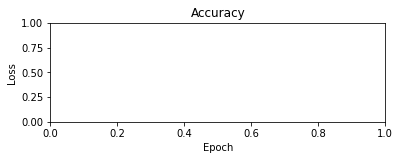

In [34]:
PtychoModel = Encoder_Decoder_Model.Model().to(device)
PtychoModel.load_state_dict(torch.load('Overnight4.pth'))
train(PtychoModel, 0.00016, 10000)

Results

In [20]:
def visualize(model):
  diff_grid = np.load('../dataset/compressed_diff_grid.npz')['arr_0']
  label = np.load('../dataset/norm_diffraction_label.npz')['arr_0']
  diff = torch.tensor(diff_grid,device=device).float()
  phase = torch.tensor(label[:, 0],device=device).float()
  amp = torch.tensor(label[:, 1],device=device).float()
  model.eval()
  phase_pred, amp_pred = model(diff)
  
  f, ax = plt.subplots(4,4, figsize=(12, 12), facecolor='white')
  ax[0,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
  ax[1,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)
  ax[2,0].set_ylabel('PtychoNeuralNetwork', fontsize = 12.0)
  ax[3,0].set_ylabel('E-Pie (300 Iterations)', fontsize = 12.0)

  ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
  ax[0,1].imshow(phase_pred[1].cpu().detach().numpy().reshape((650,650)))
  ax[0,2].imshow(phase_pred[2].cpu().detach().numpy().reshape((650,650)))
  ax[0,3].imshow(phase_pred[3].cpu().detach().numpy().reshape((650,650)))
  ax[1,0].imshow(phase[0].cpu().detach().numpy().reshape((650,650)))
  ax[1,1].imshow(phase[1].cpu().detach().numpy().reshape((650,650)))
  ax[1,2].imshow(phase[2].cpu().detach().numpy().reshape((650,650)))
  ax[1,3].imshow(phase[3].cpu().detach().numpy().reshape((650,650)))
  ax[2,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
  ax[2,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((650,650)))
  ax[2,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((650,650)))
  ax[2,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((650,650)))
  ax[3,0].imshow(amp[0].cpu().detach().numpy().reshape((650,650)))
  ax[3,1].imshow(amp[1].cpu().detach().numpy().reshape((650,650)))
  ax[3,2].imshow(amp[2].cpu().detach().numpy().reshape((650,650)))
  ax[3,3].imshow(amp[3].cpu().detach().numpy().reshape((650,650)))


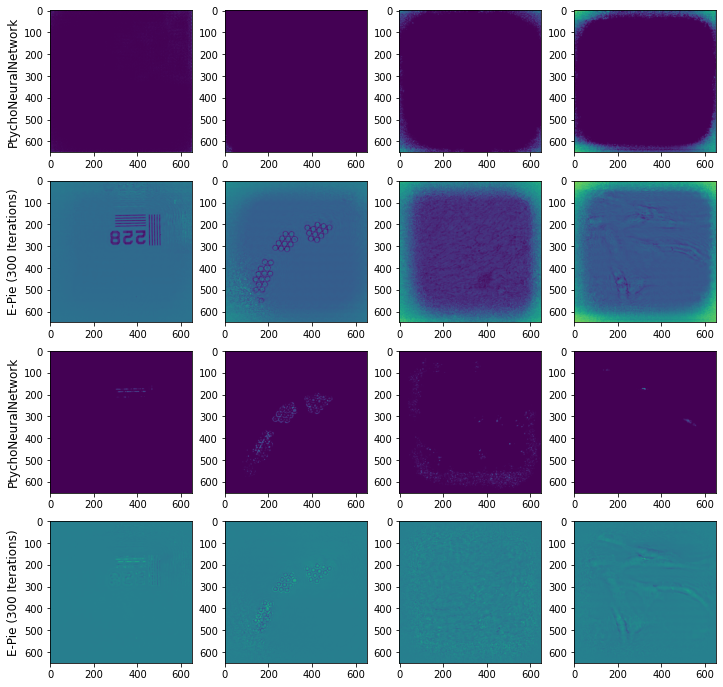

In [35]:
PtychoModel = Encoder_Decoder_Model.Model().to(device)
PtychoModel.load_state_dict(torch.load('Overnight4.pth'))
visualize(PtychoModel)